# RESOLVE Data Tutorial
This jupyter notebook illustrates use of the public RESOLVE (REsolved Spectroscopy Of a Local VolumE) survey database, including HI upper limit and confusion information. As of this writing, the HI mass census is fully available (Stark et al. 2016), but HI profile metrics are still being analyzed. The optical spectroscopic census is ~70% complete and is still being reduced and analyzed.<br/>

Note that the RESOLVE catalog and all calculations below assume H_0 = 70 km/s/Mpc, implying a combined volume for RESOLVE-A and RESOLVE-B of 52,135 cubic Mpc.<br/>

The RESOLVE website at http://resolve.astro.unc.edu/ provides further information, data, and links to papers as well as details on the ECO (Environmental COntext) catalog. ECO is a nearly ten times larger data set surrounding RESOLVE with comparable photometric and environmental data, but it has no new radio or optical spectroscopy beyond SDSS/ALFALFA. A follow-up tutorial demonstrating the use of ECO to correct for cosmic variance in RESOLVE (in the spirit of Eckert et al. 2016) will be provided soon, along with a forthcoming analysis of the bivariate HI mass function comparing RESOLVE and the Simba simulation (Kannappan, Dave, Eckert, et al., in prep.) -- check for updates at the RESOLVE website!

Author: Sheila Kannappan<br/>
Created: August 2019

### Preliminaries

In [1]:
# standard imports and naming conventions; uncomment as needed
import numpy as np              # basic numerical analysis
import matplotlib.pyplot as plt # plotting
import matplotlib as mp

%matplotlib inline

The RESOLVE DR3 csv file is provided in the same github repo as this jupyter notebook, and the README provides instructions to retrieve it. If you wish to obtain a different data release, visit the RESOLVE "searchable database" page [here](http://resolve.astro.unc.edu/pages/database.php), which includes all data releases as well as sample sql queries. The simplest possible query, `select *`, will retrieve an entire database (before clicking submit, be sure to switch the output choice from "browse the results of the query" to "download the results of the query (CSV)"). The [same page](http://resolve.astro.unc.edu/pages/database.php) provides a glossary for each data release. Open the glossary matching the data release you are using in a separate tab.

In [2]:
# read in RESOLVE DR3 csv file, assuming it is in the same directory as this jupyter notebook
data = np.genfromtxt("RESOLVE_DR3.csv", delimiter=",", dtype=None, names=True)
# alternate version below if you get an error message regarding encoding
#data = np.genfromtxt("RESOLVE_DR3.csv", delimiter=",", dtype=None, names=True, encoding=None)

If you want to look at the column names, type `data.dtype.names`, but they should match the glossary [here](http://resolve.astro.unc.edu/pages/database.php) except for possible capitalization differences.

### Sample Selection

The RESOLVE database includes galaxies that are not officially part of the survey. They may either have redshifts in the buffer range used for group-finding or have magnitudes fainter than the survey luminosity floor. In some cases data for these galaxies may be useful, but please do not expect all of it to be carefully vetted. We recommend working with one of the following sample definitions to isolate complete, high-quality data sets:<br/><br/>
1) the original luminosity- and volume-limited sample: brighter than -17.33 (A-semester) or -17.0 (B-semester) with Grpcz between 4500-7000 km/s<br/>
2) the observational sample (for new 21cm and optical spectroscopy): same as #1, but adding in galaxies with known or estimated log(M\*+1.4MHI)> 9.2 (A-semester) or 9.0 (B-semester) <br/>
3) the baryonic mass complete sample: Grpcz between 4500-7000 km/s and log Mbary> 9.2 (A-semester) or 9.0 (B-semester), where Mbary = (M\*+1.4MHI)<br/>
4) the stellar mass complete sample: Grpcz between 4500-7000 km/s and log M\*> 8.9 (A-semester) or 8.7 (B-semester)<br/><br/>
**NOTE 1:** Eckert et al. (2016, 2017) adopted higher baryonic mass completeness limits: log Mbary> 9.4 (for ECO containing RESOLVE-A) and log Mbary> 9.1 (for RESOLVE-B); note however that RESOLVE-A is more complete than ECO as a whole <br/>
NOTE 2: To simplify analysis, Stark et al. (2016) adopted a common floor for both RESOLVE-A and RESOLVE-B: log M\* > 8.9 and log Mbary > 9.3<br/>

### We will first select the original luminosity-complete data set (\#1 above).


In [3]:
grpcz = data['grpcz']
invol = (grpcz >= 4500) & (grpcz < 7000)
fl_insample = data['fl_insample'] # flag for original luminosity limits as in #1 above
inorigsample = invol & fl_insample
print("in sample %i" % np.sum(inorigsample))
print("in catalog %i" % len(inorigsample))

in sample 1443
in catalog 2286


### Before looking at the HI data, let's examine the stellar mass, color, and environment properties of this sample.

In [4]:
logmstar = data['logmstar']
urcolor = data['modelu_r']
urcolorcorr = data['modelu_rcorr'] # internal extinction-corrected, useful for sequence separation
logmhalo = data['logmh'] # use the groups/halo masses defined for the luminosity-limited sample
fc = data['fc'] # central/satellite flag (1/0)
cent = (fc == 1)
sat = (fc == 0)

In [5]:
#optionally test that these quantities are valid for all original sample galaxies
#print(np.sum(logmstar[np.where(inorigsample)] > 0))
#print(np.sum(urcolorcorr[np.where(inorigsample)] > 0))
#print(np.sum(logmhalo[np.where(inorigsample)] > 0))

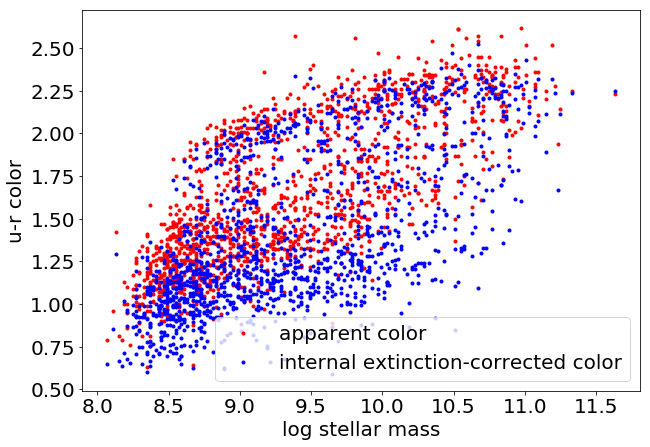

In [6]:
font = {'size' : 20}
mp.rc('font', **font)
fig1 = plt.figure(1,figsize=(10,7))
plt.clf()
plt.plot(logmstar[np.where(inorigsample)],urcolor[np.where(inorigsample)],'r.', label="apparent color")
plt.plot(logmstar[np.where(inorigsample)],urcolorcorr[np.where(inorigsample)],'b.', label="internal extinction-corrected color")
plt.xlabel("log stellar mass")
plt.ylabel("u-r color")
plt.legend(loc="best")

centrals: 1030
satellites: 413


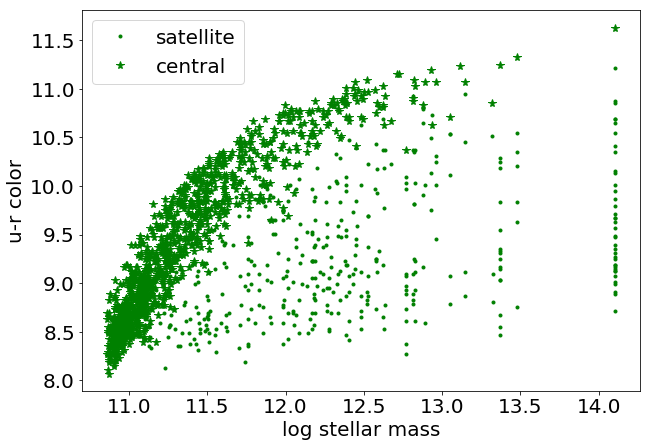

In [9]:
fig2 = plt.figure(2,figsize=(10,7))
plt.clf()
plt.plot(logmhalo[np.where(inorigsample & sat)],logmstar[np.where(inorigsample & sat)],'g.', label="satellite")
plt.plot(logmhalo[np.where(inorigsample & cent)],logmstar[np.where(inorigsample & cent)],'g*', markersize=8, label="central")
plt.xlabel("log stellar mass")
plt.ylabel("u-r color")
plt.legend(loc="best")
print("centrals: %i" % np.sum(cent[np.where(inorigsample)]))
print("satellites: %i" % np.sum(sat[np.where(inorigsample)]))

This figure serves as a useful reminder that contrary to our intuition, *most galaxies are centrals*. This follows from the steeply rising mass function of parent dark matter halos: at any halo mass, there are many more parent halos than subhalos of higher-mass halos, even though those subhalos obviously outnumber their parent halos.

### Now let's tackle the HI data.

In [8]:
radeg = data['radeg']
decdeg = data['dedeg']
asem = (radeg >= 131.25) & (radeg <= 236.25) # 8.75-15.75 hr is RESOLVE-A
bsem = (radeg >= 300) | (radeg <= 45) # 22-3 hr in RA is RESOLVE-B